In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-01-21 15:42:05.507794: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-21 15:42:05.549123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-21 15:42:05.550364: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-21 15:42:05.572730: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-21 15:42:05.585857: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-21 15:42:05.588881: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [3]:
stream = "gd1_tail"

In [4]:
df, file = load_file(stream = stream, percent_bkg = 100)

### Optional: Exclude a hotspot

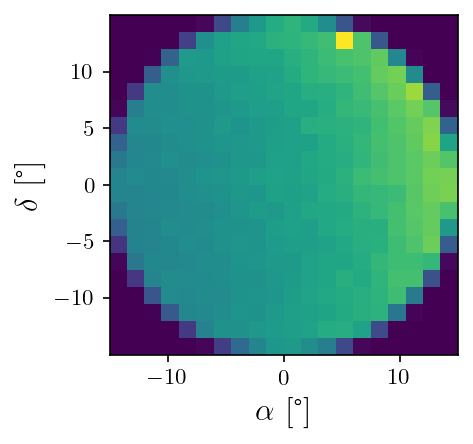

In [5]:
plt.figure(figsize=(3,3),dpi=150)
hist = plt.hist2d(df.α, df.δ, bins=20)
plt.xlabel(r'$\alpha$ [\textdegree]');
plt.ylabel(r'$\delta$ [\textdegree]');

In [6]:
# Get indices for hotspot bin to exclude
i, j = np.unravel_index(hist[0].argmax(), hist[0].shape)

# Exclude this bin based on bin edges 
df2 = df[(df.α < hist[1][i]) | (df.α > hist[1][i+1]) | 
         (df.δ < hist[1][j]) | (df.δ > hist[1][j+1])]

print("{:.1f}% of the dataset remains.".format(100*len(df2)/len(df)))

# Redefine dataframe
df = df2

99.5% of the dataset remains.


### Prepare datasets for training

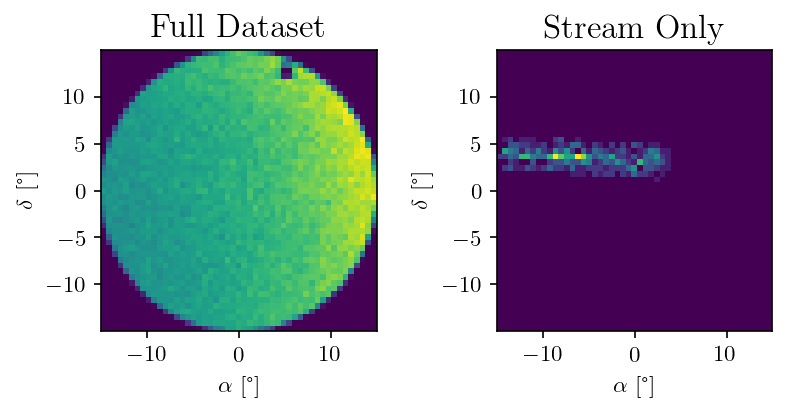

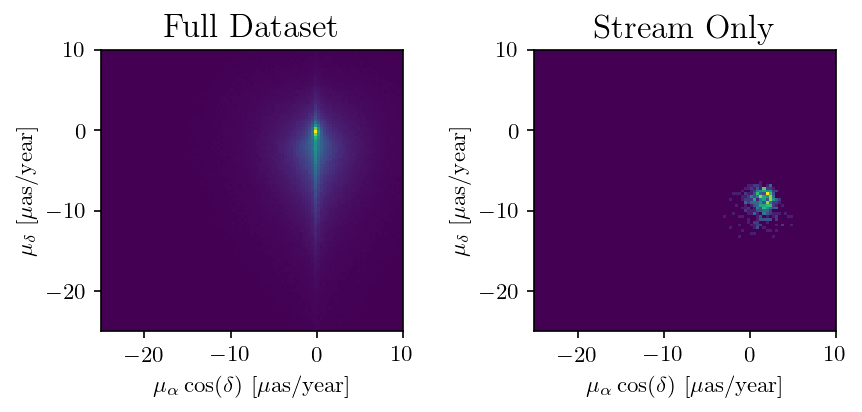

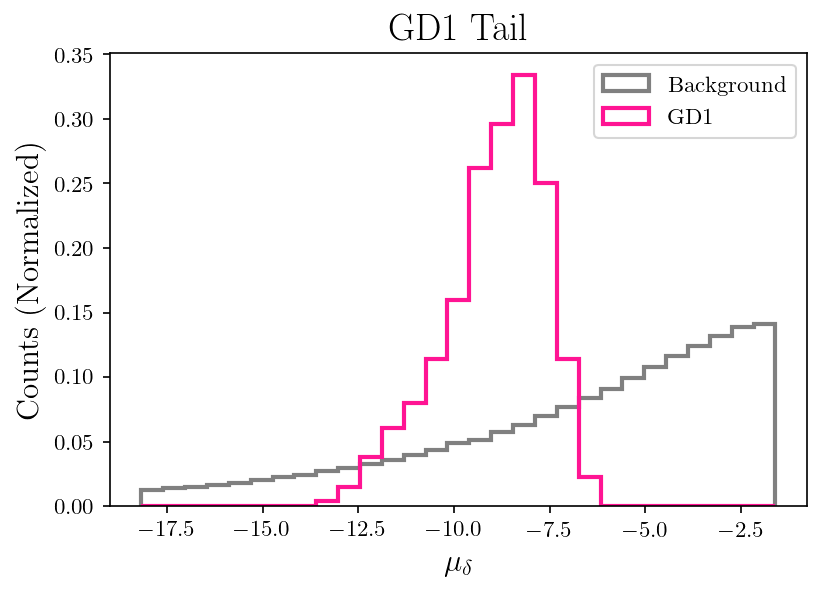

In [7]:
visualize_stream(df)

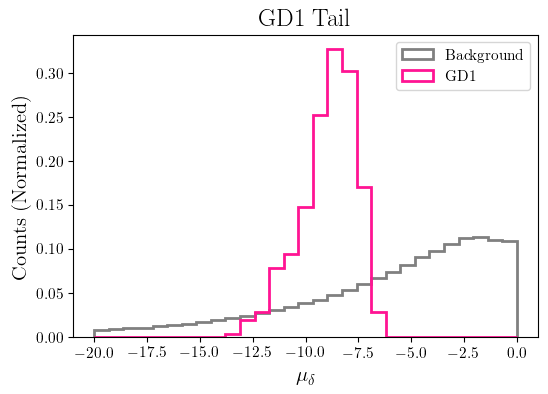

In [9]:
bins = np.linspace(-20,0,30) 
plt.hist(df[df.stream == False].μ_δ, density=True, color="gray", histtype="step", linewidth=2, 
         bins=bins, label="Background");
plt.hist(df[df.stream].μ_δ, density=True, color="deeppink", histtype="step", linewidth=2, 
         bins=bins, label="GD1")
plt.title('GD1 Tail')
plt.xlabel(r'$\mu_\delta$')
plt.ylabel('Counts (Normalized)')
plt.legend();

Sideband region: [-12.0,-6.0]
Signal region: [-11.0,-8.0]
Total counts: SR = 105,935, SB = 130,235


/clusterfs/ml4hep/mpettee/GaiaCWoLa/functions.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)
No handles with labels found to put in legend.


Signal region has 303 stream and 105,632 bkg events (0.29%).
Sideband region has 145 stream and 130,090 bkg events (0.11%).
f_sig = 2.6X f_sideband.


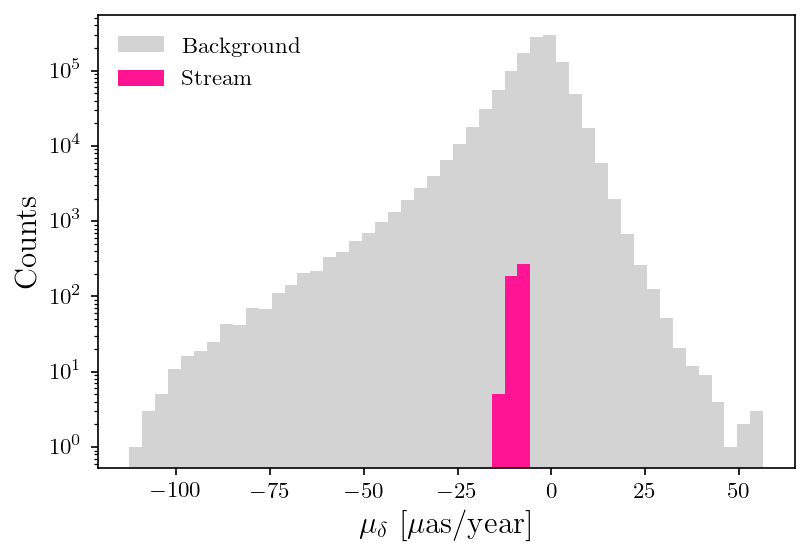

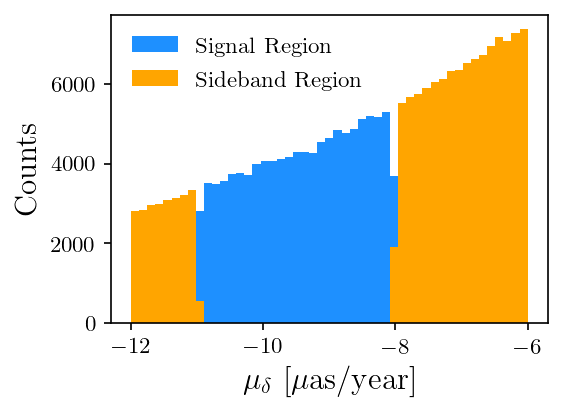

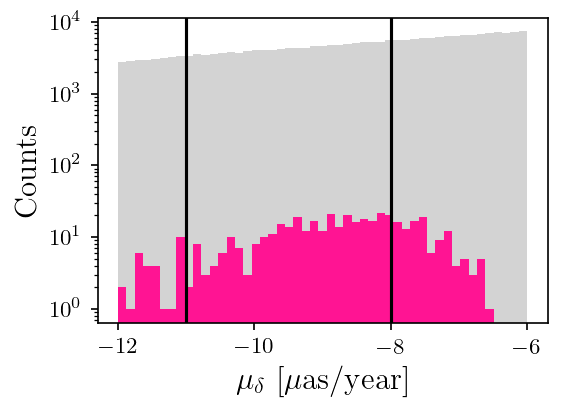

In [10]:
df = signal_sideband(df, stream = stream, )

Add sample weights to stream stars:

In [23]:
stream_weight = 4

### Throughout signal & sideband regions
df["weight"] = np.where(df['stream'] == True, stream_weight, 1)

/tmp/ipykernel_4770/3814694544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weight"] = np.where(df['stream'] == True, stream_weight, 1)


In [24]:
df.weight.value_counts()

1    355963
4       461
Name: weight, dtype: int64

# Train

In [11]:
tf.keras.backend.clear_session()

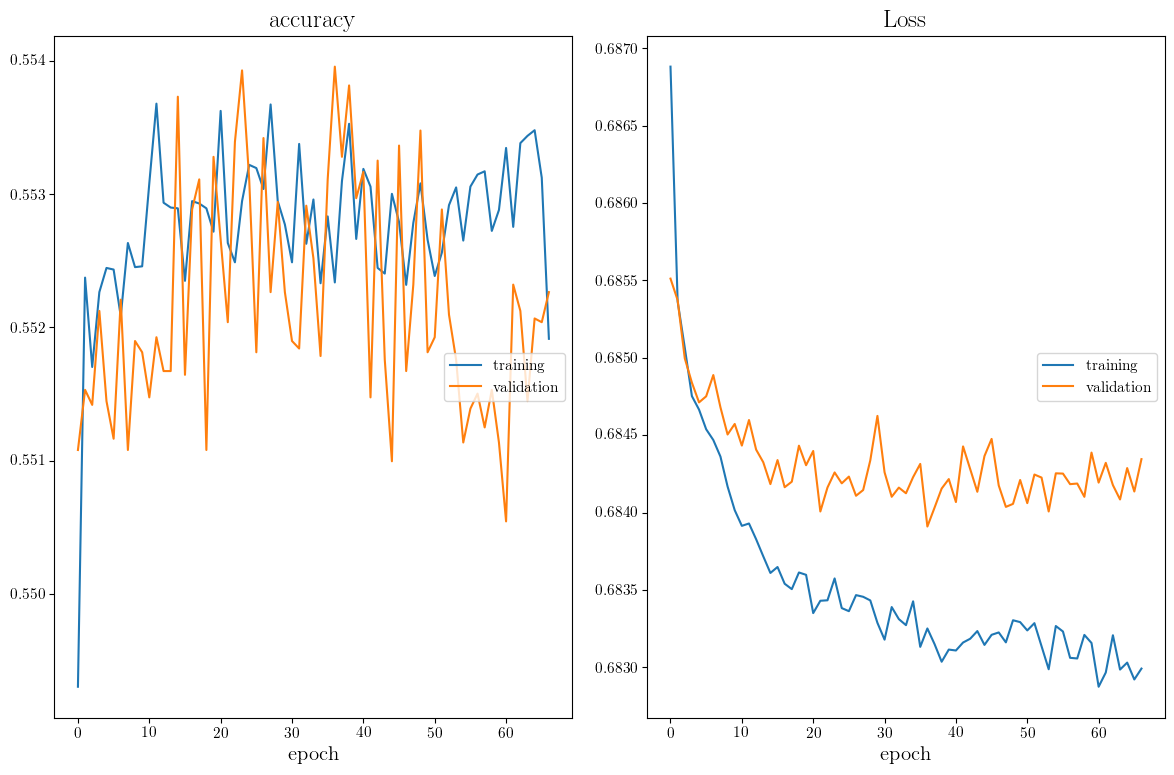

accuracy
	training         	 (min:    0.549, max:    0.554, cur:    0.552)
	validation       	 (min:    0.551, max:    0.554, cur:    0.552)
Loss
	training         	 (min:    0.683, max:    0.687, cur:    0.683)
	validation       	 (min:    0.684, max:    0.686, cur:    0.684)
1654/1654 [==============================] - 5s 3ms/step - loss: 0.6830 - accuracy: 0.5519 - val_loss: 0.6843 - val_accuracy: 0.5523
Best losses: [0.6828745603561401]
Loading weights from best loop, i.e. loop #0.
AUC: 0.553
Maximum purity of 0.0% at 46.97%
Top 10 stars: Purity = 0.0% 
Top 20 stars: Purity = 0.0% 
Top 50 stars: Purity = 0.0% 
Top 100 stars: Purity = 0.0% 


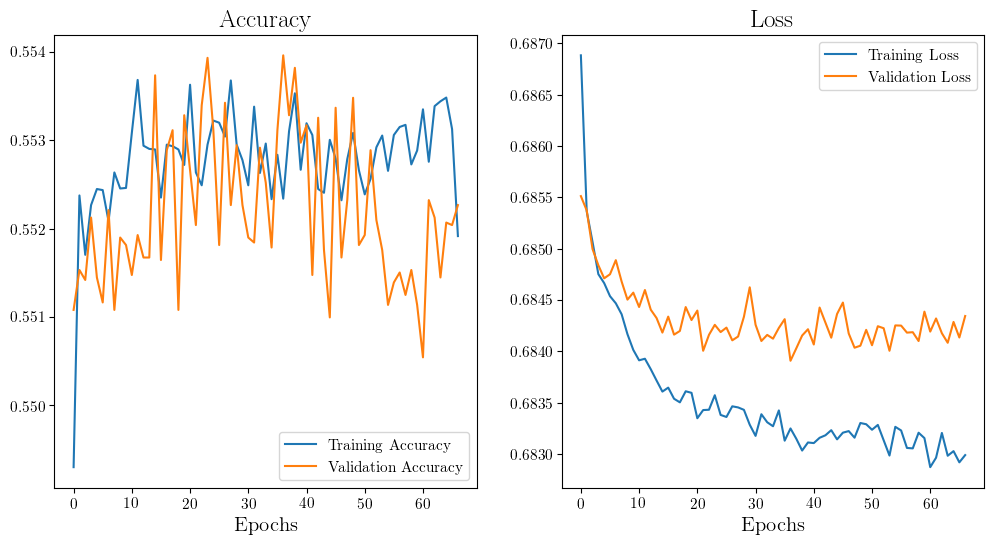

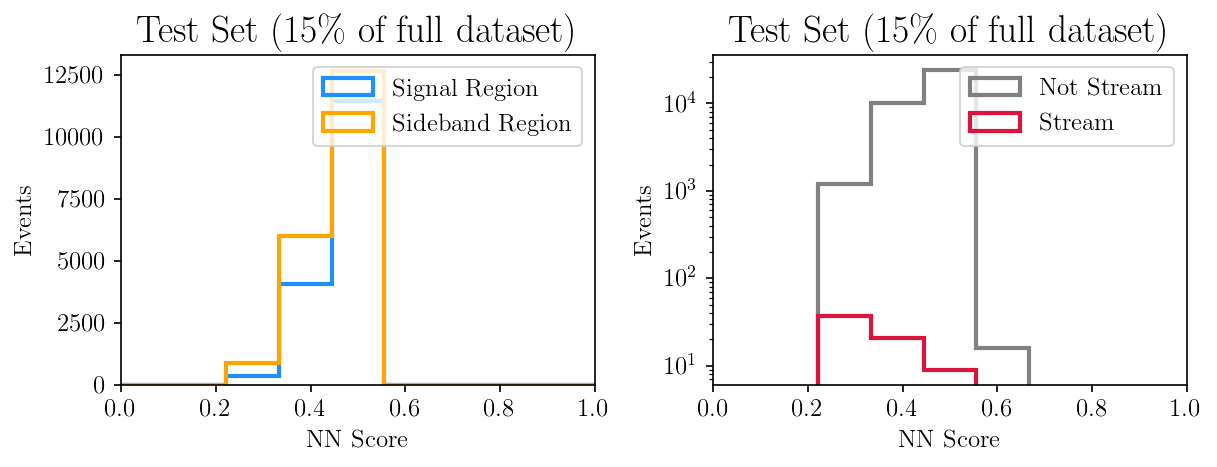

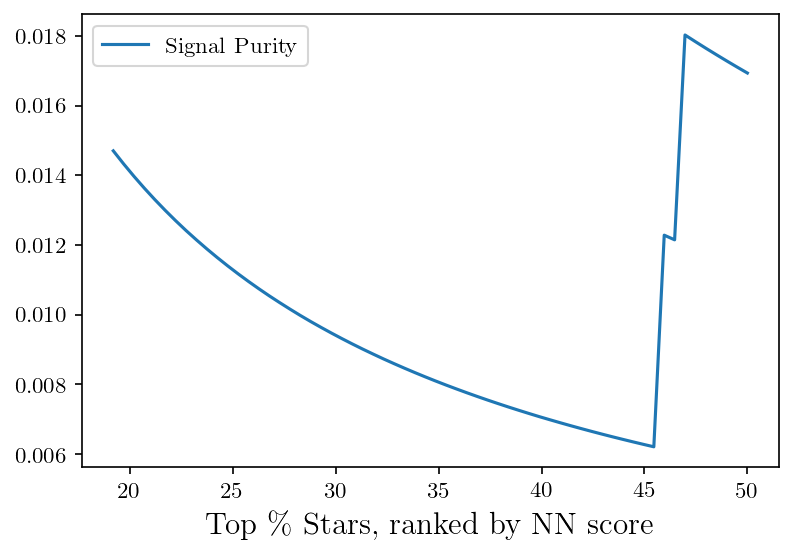

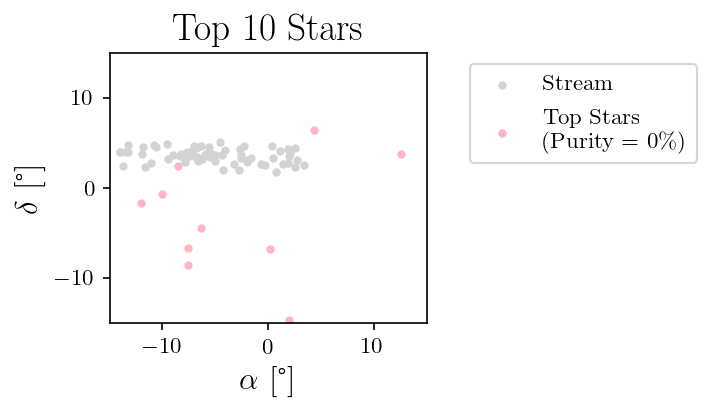

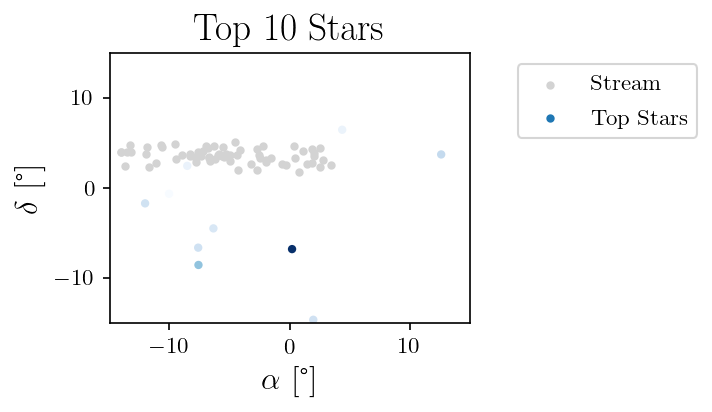

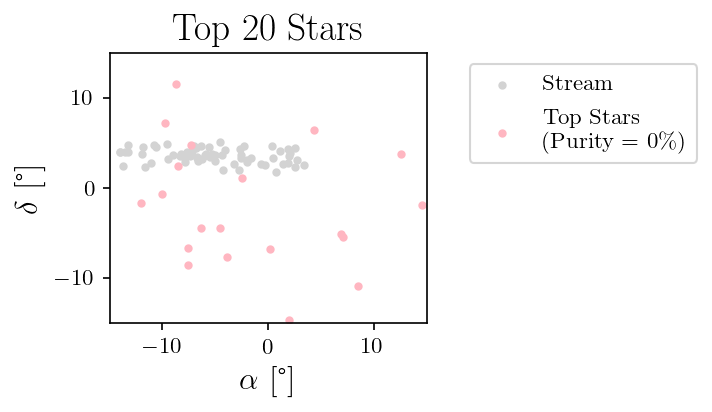

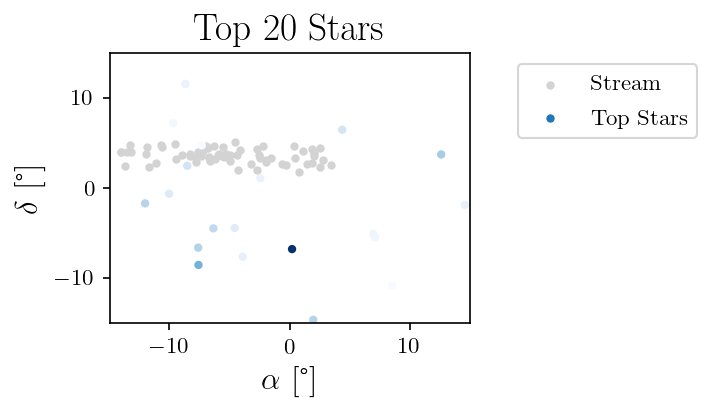

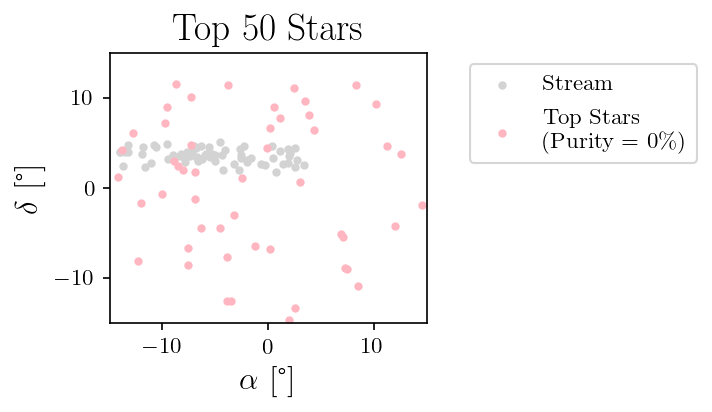

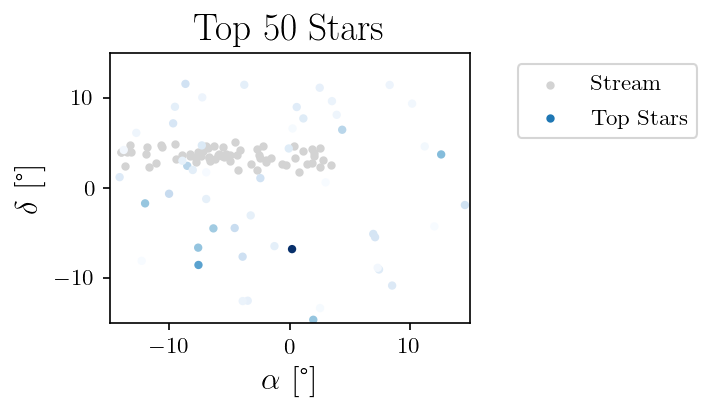

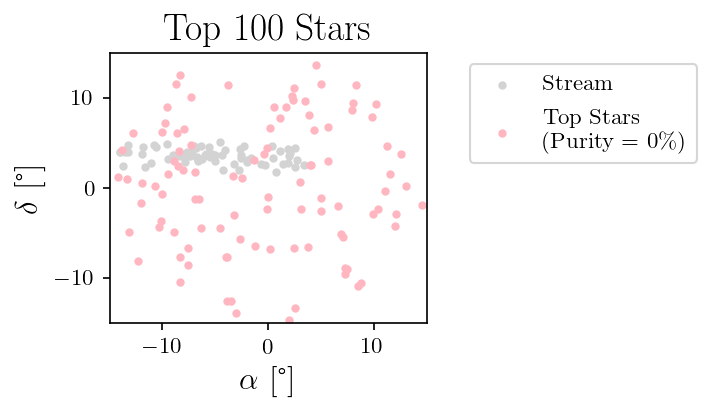

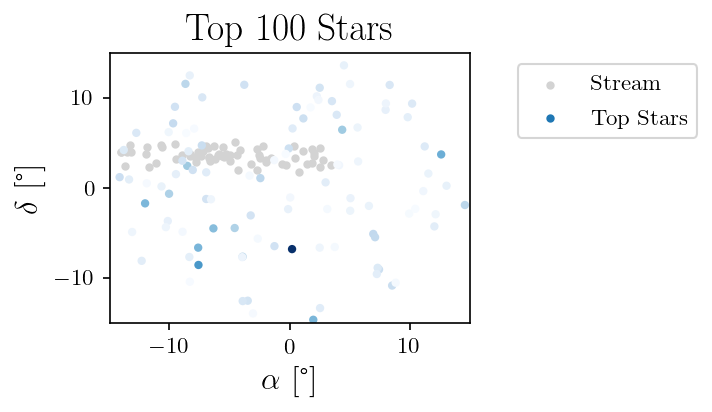

In [15]:
test = train(df, 
      n_folds = 1, 
      best_of_n_loops = 1,
      layer_size = 64, 
      batch_size = 100, 
      dropout = 0.2, 
      epochs = 500, 
      patience = 30)